In [1]:
# autoreload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from mtr.utils import common_utils
from waymax import datatypes
from waymax.agents import actor_core
from waymax import dataloader
from waymax import config as waymax_config
import tensorflow as tf
# turn off GPU in tensorflow
tf.config.experimental.set_visible_devices([], "GPU")
import numpy as np
import jax
from jax import numpy as jnp
# set jax device as cpu
jax.config.update("jax_platform_name", "cpu")
# from rl_env.env_utils import *
from typing import Dict, Tuple, List
from torch.utils.data import IterableDataset
from waymax.dynamics import bicycle_model
from tqdm import tqdm
import glob 
import os

base_path = '/Data/Dataset/Waymo/V1_2_tf/training/'
file_list = sorted(glob.glob(os.path.join(base_path, '*.tfrecord*')))


2023-12-15 15:20:30.139842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-15 15:20:30.139870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-15 15:20:30.139873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
def preprocess(
    serialized: bytes
) -> dict[str, tf.Tensor]:
    womd_features = dataloader.womd_utils.get_features_description(
        include_sdc_paths=False,
        max_num_rg_points=30000,
        num_paths=None,
        num_points_per_path=None,
    )
    womd_features['scenario/id'] = tf.io.FixedLenFeature([1], tf.string)

    deserialized = tf.io.parse_example(serialized, womd_features)
    parsed_id = deserialized.pop('scenario/id')
    deserialized['scenario/id'] = tf.io.decode_raw(parsed_id, tf.uint8)
    return dataloader.preprocess_womd_example(
        deserialized,
        aggregate_timesteps=True,
        max_num_objects=32,
    )

@jax.jit
def postprocess(example: dict[str, tf.Tensor]):
    scenario = dataloader.simulator_state_from_womd_dict(example)
    scenario_id = example['scenario/id']
    return scenario_id, scenario
    


In [7]:
fileidx = 2
cur_file = file_list[fileidx]
filename = cur_file.split('/')[-1]

def test():
  tf_dataset = dataloader.tf_examples_dataset(
    path=cur_file,
    data_format=waymax_config.DataFormat.TFRECORD,
    preprocess_fn=preprocess,
    repeat=1,
    num_shards=4,
    deterministic=True,
  )
  return tf_dataset

temp = []
for _ in range(100):
  temp.append(test())

In [74]:
@jax.jit
def find_all_valid(scenario: datatypes.SimulatorState):
    """
    Finds all valid objects that are vehicles and are moving in the given scenario.

    Parameters:
    - scenario: datatypes.SimulatorState
        The simulator state containing object metadata and trajectory information.

    Returns:
    - is_valid_vehicle_moving: bool
        A boolean array indicating whether each object is valid, a vehicle, and moving.
    """
    
    # is_sdc = scenario.object_metadata.is_sdc
    # is_modeled = scenario.object_metadata.is_modeled
    is_valid = scenario.object_metadata.is_valid
    is_vehicle = scenario.object_metadata.object_types == 1
    
    v_x_log = scenario.log_trajectory.vel_x # [num_agents, num_steps]
    v_y_log = scenario.log_trajectory.vel_y # [num_agents, num_steps]
    valid_log = scenario.log_trajectory.valid
    v_x_log = jnp.where(valid_log, v_x_log, 0)
    v_y_log = jnp.where(valid_log, v_y_log, 0)
    v_log = jnp.linalg.norm(jnp.stack([v_x_log, v_y_log], axis=-1), axis=-1)
    v_max = jnp.max(v_log, axis=-1)
    is_moving = v_max > 0.1
    
    return is_valid & is_vehicle & is_moving

@jax.jit
def find_pred(scenario: datatypes.SimulatorState):
    """
    Finds the predicted scenario based on the given SimulatorState.

    Parameters:
    - scenario: datatypes.SimulatorState
        The simulator state containing the scenario information.

    Returns:
    - bool
        True if the scenario is predicted, False otherwise.
    """
    is_sdc = scenario.object_metadata.is_sdc
    is_modeled = scenario.object_metadata.is_modeled
    is_vehicle = scenario.object_metadata.object_types == 1
    
    return is_sdc & is_modeled & is_vehicle

@jax.jit
def find_grid(scenario, t, interest_agent, accel_grid, steer_grid):
    """
    Finds the grid indices for the given scenario, time step, and validity conditions.

    Args:
        scenario: The scenario object.
        t: The time step.
        interest_agent: (num_agent,) A boolean array indicating the validity of each action.
        accel_grid: (num_accel_bins,) A 1D array containing the acceleration grid values.
        steer_grid: (num_steer_bins,) A 1D array containing the steering grid values.

    Returns:
        (num_agent, 3), A 2D array containing the grid indices and validity information.
    """
    
    action = bicycle_model.compute_inverse(scenario.log_trajectory, t)
    
    action_valid = action.valid.reshape(-1) & \
        (jnp.abs(action.data[:, 0]) < 15) & \
        (jnp.abs(action.data[:, 1]) < 0.45) & \
        interest_agent
    
    accel_idx = jnp.searchsorted(accel_grid, action.data[:, 0])
    steer_idx = jnp.searchsorted(steer_grid, action.data[:, 1])
    
    return jnp.stack([accel_idx, steer_idx, action_valid], axis=-1)

def record_cache(key, dest, grid_idx, fileidx, scenario_idx):
    i, j = key
    t_idx_array, a_idx_array = np.where(
        (grid_idx[:, :, 0] == i) &
        (grid_idx[:, :, 1] == j) &
        (grid_idx[:, :, 2] == 1)
    )
    fileidx_array = np.ones_like(t_idx_array, dtype=int)*fileidx
    scenario_idx_array = np.ones_like(t_idx_array, dtype=int)*scenario_idx
    match_idx = np.stack([fileidx_array,scenario_idx_array, t_idx_array, a_idx_array], axis=-1)
    dest.extend(match_idx.tolist())
    
    

In [75]:
accel_grid = jnp.linspace(-10, 10, 20)
steer_grid = jnp.linspace(-0.3, 0.3, 20)

idx_cache = {}
for i in range(len(accel_grid)):
    for j in range(len(steer_grid)):
        idx_cache[(i, j)] = []

In [76]:
full_iter = tf_dataset.as_numpy_iterator()

for scenario_idx, example in tqdm(enumerate(full_iter)):
    scenario_id_binary, scenario = postprocess(example)
    scenario_id = scenario_id_binary.tobytes().decode('utf-8')
    scenario: datatypes.SimulatorState
    interest_agent = find_pred(scenario)
    
    # Find corresponding grid indices of each agnet at each time step of the scenario
    grid_idx = jax.vmap(find_grid, in_axes=(None, 0, None, None, None))(scenario, jnp.arange(90), interest_agent, accel_grid, steer_grid)
    grid_idx = np.asarray(grid_idx)
    for key, dest in idx_cache.items():
        record_cache(key, dest, grid_idx, fileidx, scenario_idx)

471it [00:04, 97.99it/s] 


In [77]:
histogram = np.zeros((len(accel_grid), len(steer_grid)), dtype=int)
for key, dest in idx_cache.items():
    i,j = key
    histogram[i,j] = len(dest)

In [93]:
print()

[[2, 107, 49, 1], [2, 301, 13, 3], [2, 425, 78, 6]]


In [101]:
accel_grid[8], steer_grid[6]

(Array(-1.5789472, dtype=float32), Array(-0.11052632, dtype=float32))

In [108]:
# retrive scenario verify

cache = idx_cache[(7, 9)][2]
scenario_idx = cache[1]
t_idx = cache[2]
a_idx = cache[3]

example = next(tf_dataset.skip(scenario_idx).take(1).as_numpy_iterator())
scenario_id_binary, scenario = postprocess(example)
scenario_id = scenario_id_binary.tobytes().decode('utf-8')

action = bicycle_model.compute_inverse(scenario.log_trajectory, t_idx)
jnp.searchsorted(accel_grid, action.data[a_idx, 0]), jnp.searchsorted(steer_grid, action.data[a_idx, 1])

(Array(7, dtype=int32), Array(9, dtype=int32))

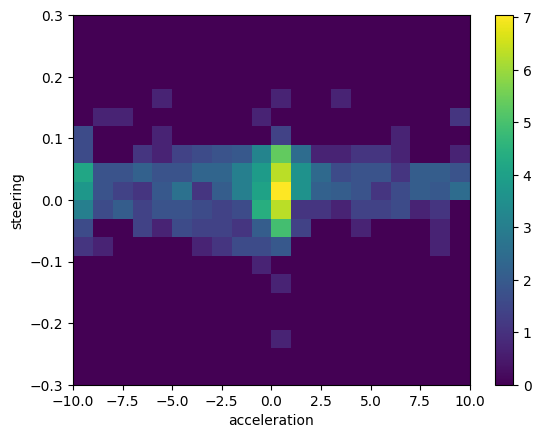

In [90]:
# display histogram
import matplotlib.pyplot as plt
plt.imshow(np.log(histogram+1), extent=[-10, 10, -0.3, 0.3], origin='lower', aspect='auto')
plt.xlabel('acceleration')
plt.ylabel('steering')
plt.colorbar()
plt.show()

